# Import packages

### Import python packages

In [1]:
import re,os,glob
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
from MRA_generate import MRA_generate
from parameters import *
import symae_core as symae
from movie_redatum import movie_redatum 

# Generate dataset X

In [2]:
d

100

### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    if n==0:
        return int(x<0.5)
    elif n==1:
        return math.cos(2*math.pi*x)/2 + 0.5
    elif n==2:
        if x<0.5: 
            return 1-2*x
        else:     
            return 0
    elif n==3:
        return 2*int(x<0.5)-1
    elif n==4:
        return math.cos(2*math.pi*x)
    elif n==5:
        if x<0.5: 
            return 1-4*x
        else:     
            return -1

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 6 states')

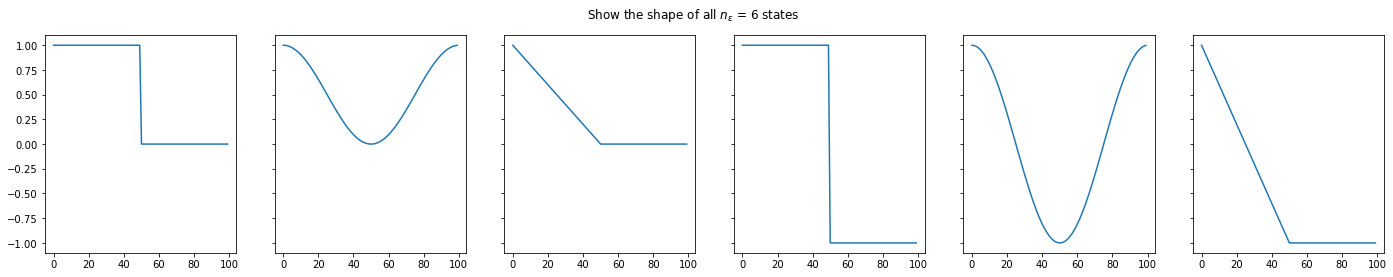

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

In [5]:
MRA_training = MRA_generate(d,nt,N,0,ne,g,replace=0,continuous=False)
while np.min(np.sum(MRA_training.select_times,axis=1))==0:
    MRA_training.generate_default()
X = MRA_training.X
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

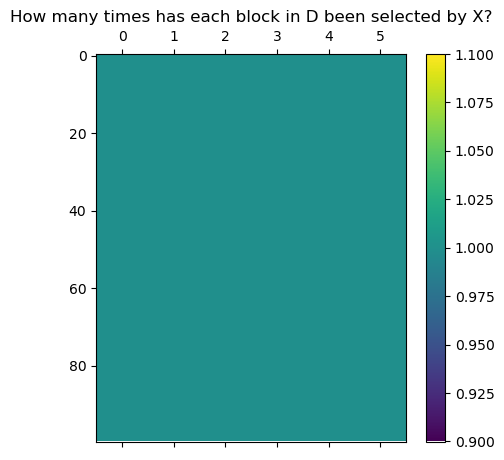

In [6]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [7]:
nt

20

### Layer

In [8]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=0.5):
        super(LatentCat, self).__init__(name = 'latentcat')
        self.drop = tfkl.Dropout(alpha)
    def call(self, zsym, znuisance, training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [9]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, d, p, q, r): 
        super(SymAE, self).__init__()
        sym_encoder = symae.SymmetricEncoder1D(p)
        self.sym_encoder = sym_encoder
        nui_encoder = symae.NuisanceEncoder1D(q)
        self.nui_encoder = nui_encoder
        sym_dec = symae.DecDense1()
        self.sym_dec = sym_dec
        nui_dec = symae.DecDense2()
        self.nui_dec = nui_dec
        dec = symae.DecDense()
        self.dec = dec
        drop = tfkl.Dropout(r)
        self.drop = drop
        repeat = tfkl.RepeatVector(nt)
        self.repeat = repeat
        
        # Build 
        input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        zsym = sym_encoder(input)
        zsym = repeat(zsym)
        znui = nui_encoder(input)
        y1 = sym_dec(zsym)
        y2 = nui_dec(znui)
        #tf.print(y1.shape,y2.shape)
        y = y1*y2
        output = dec(y)
        model = tfk.Model(input,output, name="coder") 
        self.model = model
        
    def call(self, x):
        return self.model(x)
    def redatum(self, x1, x2):
        Zs = model.sym_encoder(x1)
        Zs = model.repeat(Zs)
        Zn = model.nui_encoder(x2)
        y1 = model.sym_dec(Zs)
        y2 = model.nui_dec(Zn)
        y = y1*y2
        output = model.dec(y)
        return output

### Initialize SymAE and load weights

In [10]:
my_list=[(2, 10, 0.5, 0)
        ]

In [11]:
for (p,q,r,lam) in my_list:
    path = './ber,N=%d,nt=%d,p=%d,q=%d,r=%.1f,l=%.2f'%(N,nt,p,q,r,lam)    
    model = SymAE(N,nt,d,p,q,r)
    clear_output()
    try: 
        model.load_weights(path+'/checkpoint')
        print("old")    
    except:
        print("new")
    optimizer = tf.keras.optimizers.Adam(0.001)
    mse = tf.keras.losses.MeanSquaredError()

    def reconstruction_loss(model, x, training=False):
        x_hat = model(x+np.random.normal(size=X.shape,scale=0.1), training=True)
        return mse(x, x_hat)
    @tf.function
    def train_step(model, x, training=True):
        with tf.GradientTape() as tape:
            loss_rec = reconstruction_loss(model, x, training)
            loss_cor = 0
            loss = loss_rec + loss_cor
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss_rec, loss_cor

    try:
        os.mkdir(path)
    except:
        print('exists')
    try:
        epoch = int(re.findall(r"\d+",glob.glob(path+'/*.epoch')[0])[-1])
        print(epoch)
    except:
        epoch = 0
        os.mkdir(path+'/0.epoch')

    for i in range(10000):
        epoch += 1
        os.mkdir(path+'/%d.epoch'%epoch)
        os.rmdir(path+'/%d.epoch'%(epoch-1))    
        loss_rec, loss_cor = train_step(model, X)
        print("For epoch {:d}, reconstruction loss is {:f}, correlation loss is {:f}."
              .format(epoch, loss_rec, loss_cor))
        clear_output(wait=True)

    model.save_weights(path+'/checkpoint')
    print("weights saved")

    #fig = movie_redatum(g,model)
    #fig.savefig(path+"/redatum.pdf", format='pdf', dpi=200)

weights saved


100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.52s/it]


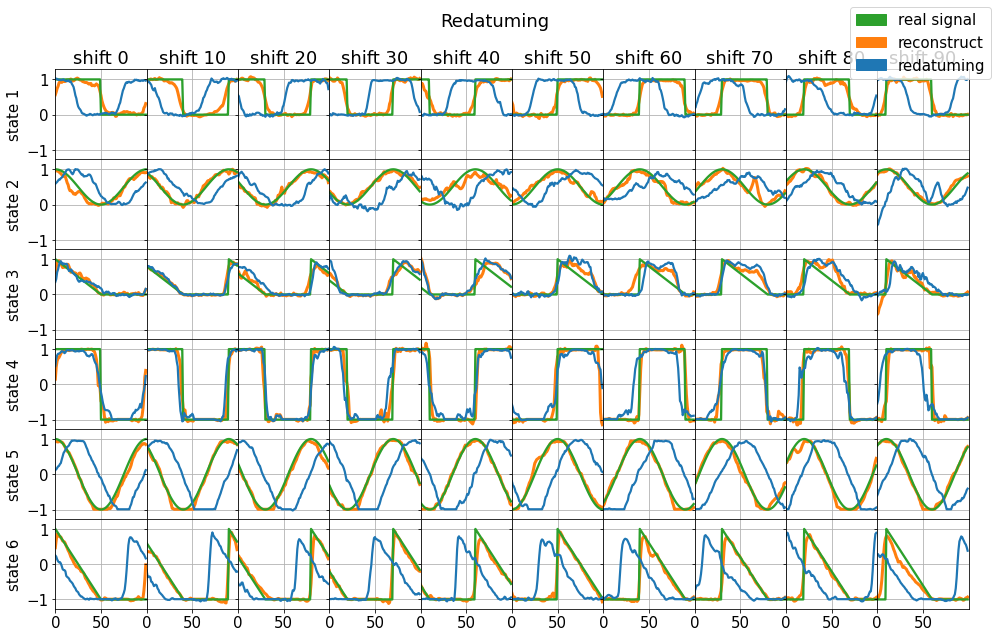

In [12]:
fig = movie_redatum(g,model)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 26.35it/s]


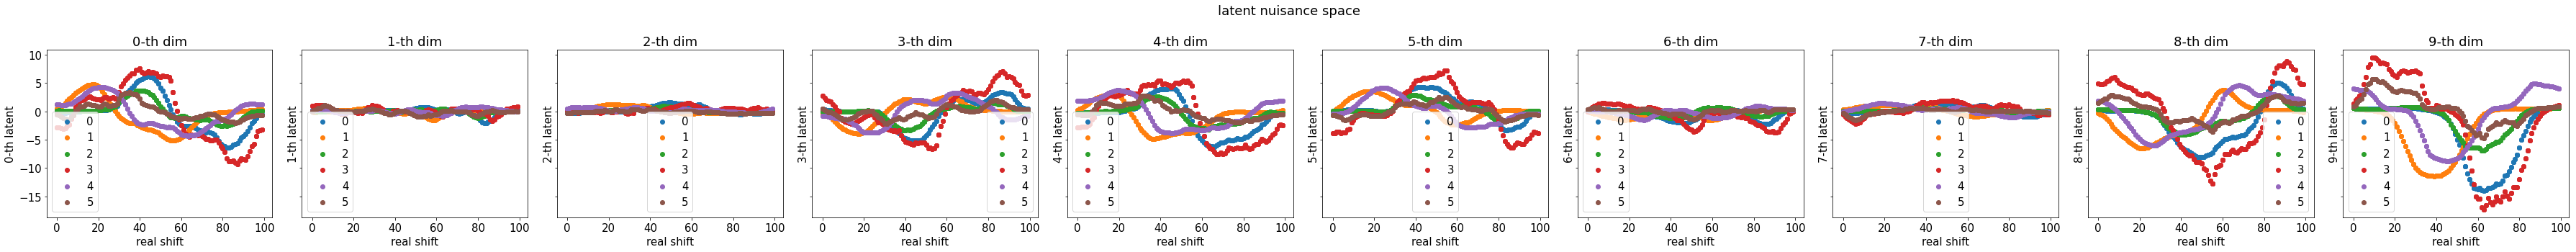

In [13]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nu/i_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]
fig, axs = plt.subplots(1, q, sharex=True, sharey=True, figsize=(q*5,5))
for i in trange(q):
    for s in range(ne):
        ax=axs[i]
        ax.scatter(N_shifts[s_sub[s]],N_reshaped[:,i][s_sub[s]],color='C%d'%s,label=s)
        ax.set_title('%d-th dim'%i)
        ax.set_xlabel('real shift')
        ax.set_ylabel('%d-th latent'%i)
        ax.legend()
        ax.grid()
fig.suptitle('latent nuisance space')
fig.show()
fig.tight_layout()
fig.savefig(path+"/redatum_all.pdf", format='pdf', dpi=200)